 2) Design a combinatorial bandit algorithm to optimize the budget allocation over the three subcampaigns
  to maximize the total number of clicks. Plot the cumulative regret.
prima si stimano le curve (budget allocato -> numero di click + rumore gaussiano)\n",
poi crea la tabella e si trova la combinazione migliore di sub per avere il massimo numero di click\n",


    CURVE\n",
    MAX_BUDGET * (1.0 - np.exp(-(PARAMETRO_SUB * x))\n",

    RUMORE: generazione sample con rumore\n",
    SAMPLE = np.random.normal(CLICK_Y_CURVA, VARIANZA_FISSA)\n",
    CLICK_Y_CURVA = valore del numero di click preso dalla curva dato un budget x\n",

   Dai vari SAMPLE si generano le  3 CURVA_GEN con un GP\n",

    Dalle curve si riempie la prima tabella con i valori di budget prefissati:
    0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100

    Si applica l'optimization problem per decidere la combinazione migliore di subcampaign

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from project.Urbano08.BiddingEnvironment import BiddingEnvironment
from project.Urbano08.Learner import Learner

In [2]:
n_obs = 50
x_obs = np.ndarray(shape=(0,3), dtype=float)
print(x_obs.shape)
y_obs = np.ndarray(shape=(0,3), dtype=float)
print(y_obs.shape)

n_subcamp = 3

max_bid = 1
max_clicks = 100
n_arms = 11

noise_std = 6.0

bids = np.linspace(0, max_bid, n_arms)
print(bids)

env = BiddingEnvironment(bids,max_clicks,noise_std)
learners = []

for i in range(0, n_subcamp):
    learners.append(Learner(n_arms,bids))

(0, 3)
(0, 3)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [3]:
for i in range(0, n_obs):
    clicks = []
    pulled = [l.pull_arm() for l in learners]


    clicks = env.round(pulled[0],pulled[1],pulled[2])
    for x in range(0,len(learners)):
        learners[x].update(pulled[x], clicks[x])
    y_obs = np.append(y_obs,np.atleast_2d(clicks),0)
    x_obs = np.append(x_obs,np.atleast_2d(bids[pulled]),0)

print(y_obs.shape)
print(x_obs.shape)

(50, 3)
(50, 3)


[0.  0.1 0.2 0.8 0.5 0.3 1.  0.7 1.  0.  0.5 0.8 1.  0.3 0.6 0.  0.4 0.9
 0.2 0.6 1.  0.  0.8 0.4 0.2 1.  0.  0.6 0.8 0.4 0.1 0.9 0.7 0.2 0.  1.
 0.6 0.4 0.  1.  0.2 0.8 0.5 0.  0.3 1.  0.8 0.6 0.2 1. ]
[  0.          45.48076747  64.44241498 108.15531724  96.367474
  76.06247381  93.51812752  94.04569286 111.58484921   4.75145152
  92.39490347  98.5836604   97.67945714  84.2265679   96.67162148
   0.21766386  76.79469873  97.25599999  61.0924461   97.12990819
 106.35562819   5.98885881  97.83673034  83.953156    54.66005228
  91.38435465   0.         101.18936289  99.20821636  81.80449397
  48.61462642 104.61719731 103.10986444  47.94546252   2.68377611
  96.10829025  99.27315955 100.39899216   0.         104.88570529
  63.44317302  86.96914659  99.29752508   0.          76.1179579
 105.09803089 107.01400219 101.09063016  57.79038161  91.86205755]


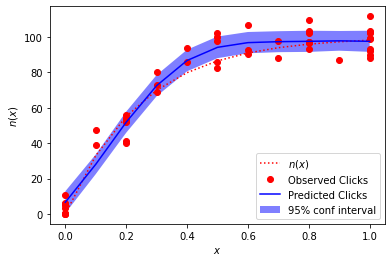

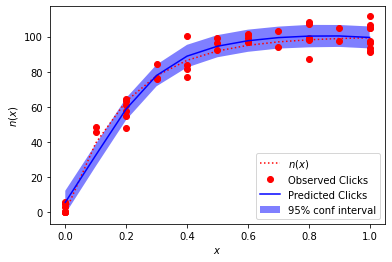

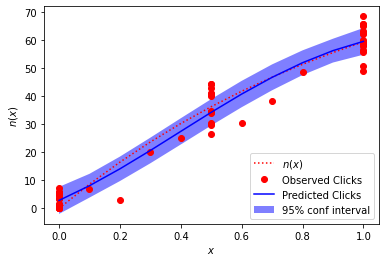

In [4]:
x_pred = np.atleast_2d(bids).T
print(x_obs[:,1])
print(y_obs[:,1])
for i in range(0,len(learners)):

    X = np.atleast_2d(x_obs[:,i]).T
    Y = y_obs[:,i].ravel()

    plt.figure()

    plt.plot(x_pred, env.subs[i](x_pred), 'r:', label=r'$n(x)$')
    plt.plot(X.ravel(), Y, 'ro', label=r'Observed Clicks')
    plt.plot(x_pred, learners[i].means, 'b-', label=r'Predicted Clicks')
    plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([learners[i].means - 1.96 * learners[i].sigmas, (learners[i].means + 1.96 * learners[i].sigmas)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% conf interval')
    plt.xlabel('$x$')
    plt.ylabel('$n(x)$')
    plt.legend(loc='lower right')
    plt.show()

Ora va sviluppato l'algoritmo della tabella
per prendera l'alloacazione migliore

budget1 + budget2 + budget3 = 1

In [ ]:
table_all_Subs = np.ndarray(shape=(0,len(bids)), dtype=float)
for l in learners:
    np.append(l.means)
